In [32]:
import pandas as pd 
import matplotlib.pyplot as plt 
import hddm 
from patsy import dmatrix 
import numpy as np
# print(hddm.__version__)

%matplotlib inline
plt.rcParams['figure.figsize'] = 30, 10

## Pre-processing

In [33]:
!pwd
write_dir = '/Users/67981492/Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis/hddm_reg_models/'

/Users/67981492/Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis/analysis_nbs


In [34]:
#using raw data because cleaning obscures rt profiles...
all_data = hddm.load_csv('/Users/67981492/Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis/aggregated_data/new_cleaned_probC_data_test.csv')

In [35]:
#learning signals 
learning_signals = hddm.load_csv('/Users/67981492/Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis/aggregated_data/probC_sim_learning_signals.csv')

In [36]:
#need to check data structure 
learning_signals.head(10)
learning_signals.columns = learning_signals.columns.str.strip()

In [ ]:
#map so that subject index corresponds to ID  
#give explicit lists, see data aggregation code
# np.map(learning_signals.subj_idx, all_data.ID)

In [37]:
all_data.head(10)

,Unnamed: 0,choice,accuracy,solution,reward,cumulative_reward,rt,total_trial_time,iti,cp_with_slow_fast,obs_cp_with_slow_fast,high_val_cue,ID,condition
0,0,1.0,1.0,1.0,3.0,602.0,0.554065,1.863330,0.315112,0.0,0.0,112.0,776,lv
1,1,0.0,1.0,0.0,5.0,606.0,0.422159,1.721799,0.320283,0.0,0.0,112.0,776,lv
2,2,0.0,1.0,0.0,1.0,606.0,0.310826,2.001336,0.704584,0.0,0.0,112.0,776,lv
3,3,0.0,0.0,1.0,0.0,605.0,0.256866,1.748328,0.503199,0.0,1.0,111.0,776,lv
4,4,0.0,1.0,0.0,2.0,606.0,0.229932,1.606700,0.376770,0.0,1.0,112.0,776,lv
5,5,1.0,1.0,1.0,3.0,608.0,0.506960,1.837049,0.347257,0.0,0.0,112.0,776,lv
6,6,1.0,1.0,1.0,2.0,609.0,0.424644,2.125723,0.722677,0.0,0.0,112.0,776,lv
7,7,1.0,1.0,1.0,2.0,610.0,0.251600,1.729187,0.485486,0.0,0.0,112.0,776,lv
8,8,0.0,1.0,0.0,4.0,613.0,0.282125,2.020255,0.738909,0.0,0.0,112.0,776,lv
9,9,0.0,1.0,0.0,5.0,617.0,0.216536,1.611865,0.401168,0.0,0.0,112.0,776,lv


In [38]:
data = all_data[['accuracy', 'rt', 'condition', 'ID']] 
data = data.rename(index=str, columns={"accuracy": "response", "ID": "subj_idx", "condition": "stim"})

In [39]:
data.columns = data.columns.str.strip()
data['stim'] = data['stim'].str.strip()
data.head()

,response,rt,stim,subj_idx
0,1.0,0.554065,lv,776
1,1.0,0.422159,lv,776
2,1.0,0.310826,lv,776
3,0.0,0.256866,lv,776
4,1.0,0.229932,lv,776


In [40]:
data = hddm.utils.flip_errors(data)

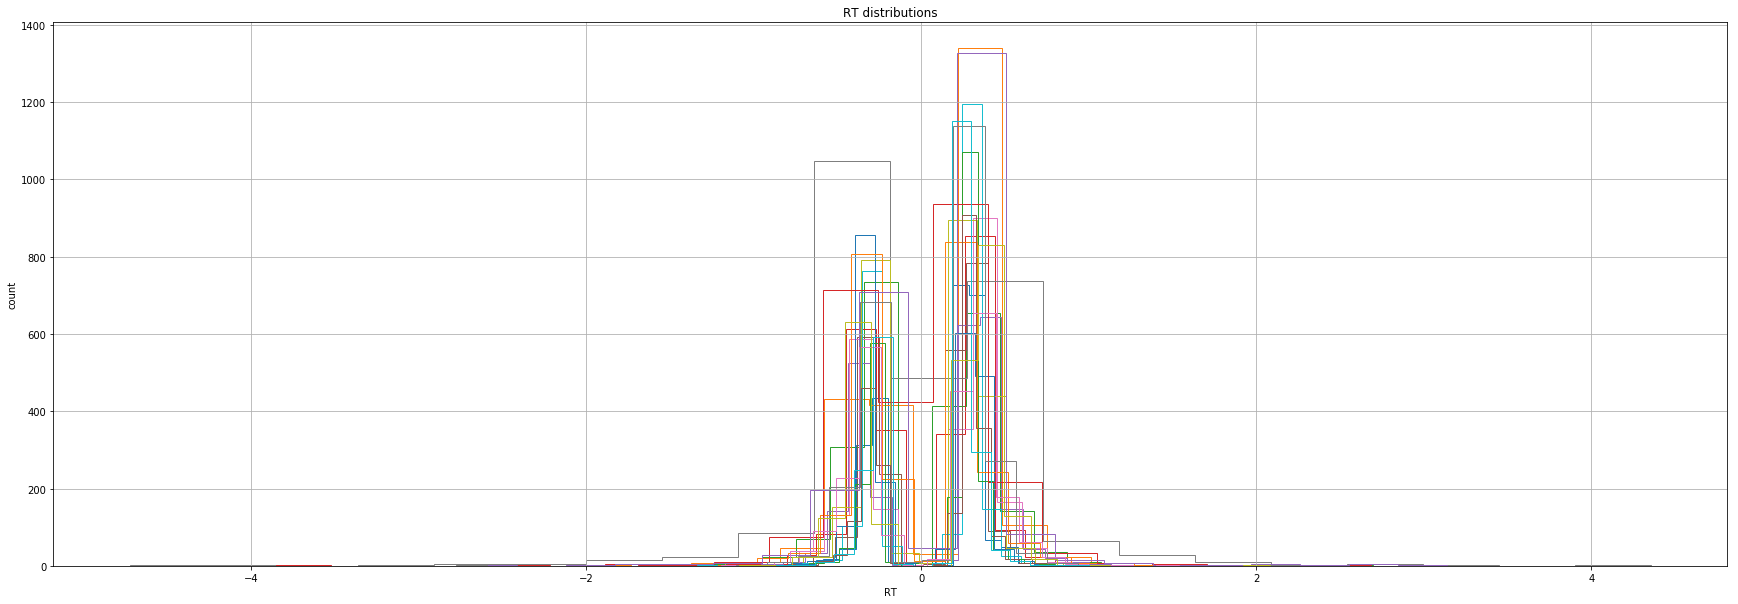

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

In [42]:
np.unique(data.subj_idx), np.unique(data.stim), len(np.unique(data.subj_idx))

(array([761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773,
        775, 776, 777, 778, 779, 780, 781]),
 array(['hc', 'hv', 'lc', 'lv'], dtype=object),
 20)

## Within-subjects regression 

#### Treatment specifies intercept (comparison condition) 
#### C(x) specifies categorical predictor 

##### (design matrix will auto-code dummy variables)

#### trialwise response ~ categorical predictor, intercept condition 

In [43]:
formula="0+C(stim)"
d_mat = dmatrix(formula, data)
print(d_mat.design_info.column_names)
print(d_mat)
sum(d_mat)

['C(stim)[hc]', 'C(stim)[hv]', 'C(stim)[lc]', 'C(stim)[lv]']
[[ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 ..., 
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]]


array([ 12094.,  12093.,  12098.,  12040.])

In [44]:
d_mat

DesignMatrix with shape (48325, 4)
  C(stim)[hc]  C(stim)[hv]  C(stim)[lc]  C(stim)[lv]
            0            0            0            1
            0            0            0            1
            0            0            0            1
            0            0            0            1
            0            0            0            1
            0            0            0            1
            0            0            0            1
            0            0            0            1
            0            0            0            1
            0            0            0            1
            0            0            0            1
            0            0            0            1
            0            0            0            1
            0            0            0            1
            0            0            0            1
            0            0            0            1
            0            0            0            1
           

In [45]:
v_reg_model = "v ~"+ formula
a_reg_model = "a ~"+ formula
av_reg_model = [v_reg_model, a_reg_model]

In [ ]:
#using the raw data but 

In [ ]:
v_within_subj_obs = hddm.HDDMRegressor(data, v_reg_model)
v_within_subj_obs.sample(5000,burn=200,dbname='v_traces_obs_raw.db', db='pickle')

Adding these covariates:
['v_C(stim)[hc]', 'v_C(stim)[hv]', 'v_C(stim)[lc]', 'v_C(stim)[lv]']


/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------45%                  ] 2294 of 5000 complete in 6395.8 sec

In [ ]:
a_within_subj_obs = hddm.HDDMRegressor(data, a_reg_model)
a_within_subj_obs.sample(5000,burn=200,dbname='a_traces_obs_raw.db', db='pickle')

In [ ]:
av_within_subj_obs = hddm.HDDMRegressor(data, av_reg_model)
av_within_subj_obs.sample(5000,burn=200,dbname='av_traces_obs_raw.db', db='pickle')

#### save models

In [ ]:
v_within_subj_obs.save(write_dir+'v_within_subj_observed_raw')
a_within_subj_obs.save(write_dir+'a_within_subj_observed_raw')
av_within_subj_obs.save(write_dir+'av_within_subj_observed_raw')

#### extract DIC score

In [ ]:
v_within_subj_obs.dic, a_within_subj_obs.dic, av_within_subj_obs.dic

#### plot within-subjects effects for winning model

In [ ]:
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

names = [r'$v$',r'$a$',r'$a+v$']
dics = [v_within_subj_obs.dic,  a_within_subj_obs.dic, av_within_subj_obs.dic]
bars = plt.barh(names,dics, alpha=0.5)
plt.xlabel('DIC score')

bars[0].set_color('r')
bars[1].set_color('blue')
bars[2].set_color('forestgreen')

plt.axvline(av_within_subj_obs.dic, color='k', alpha=0.5, linestyle = '--')

In [ ]:
v_hc, v_hv, v_lc, v_lv = av_within_subj_obs.nodes_db.ix[['v_C(stim)[hc]', 'v_C(stim)[hv]', 'v_C(stim)[lc]', 'v_C(stim)[lv]'], 'node']


drift_fig=hddm.analyze.plot_posterior_nodes([v_hc, v_hv, v_lc, v_lv])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('All groups: Group mean posteriors of within-subject drift-rate effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

In [ ]:
drift_fig=hddm.analyze.plot_posterior_nodes([v_hc, v_lc])
plt.xlabel('drift-rate')
plt.ylabel('Density of posterior probability')
plt.savefig(write_dir+'drift_post_conf.pdf')

In [ ]:
drift_fig=hddm.analyze.plot_posterior_nodes([v_hc, v_hv, v_lc, v_lv])
plt.xlabel('drift-rate')
plt.ylabel('Density of posterior probability')
plt.savefig(write_dir+'drift_all.pdf')

In [ ]:
a_hc, a_hv, a_lc, a_lv  = av_within_subj_obs.nodes_db.ix[['a_C(stim)[hc]', 'a_C(stim)[hv]', 'a_C(stim)[lc]', 'a_C(stim)[lv]'], 'node']
bound_fig = hddm.analyze.plot_posterior_nodes([a_hc, a_hv, a_lc, a_lv])
plt.xlabel('decision threshold')
plt.ylabel('Density of posterior probability')
plt.savefig(write_dir+'thrs_all.pdf')

In [ ]:
bound_fig = hddm.analyze.plot_posterior_nodes([a_hv, a_lv])
plt.xlabel('decision threshold')
plt.ylabel('Density of posterior probability')
plt.savefig(write_dir+'thrs_vol.pdf')

#### Hypothesized contrasts

In [ ]:
hddm.analyze.plot_posterior_nodes([a_lv, a_hv])
plt.xlabel('bound')
plt.ylabel('Posterior probability')
plt.title('Volatility: Group mean posteriors of within-subject bound effects.')

In [ ]:
hddm.analyze.plot_posterior_nodes([v_hc, v_lc])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Conflict: Group mean posteriors of within-subject drift-rate effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

#### all stats

In [ ]:
# v_within_subj.print_stats()

In [ ]:
m.plot_posterior_predictive(figsize=(14, 10))

In [ ]:
# tst hyp. that bound ^ with vol
print("P(HV > LV) = ", (a_hv.trace() > a_lv.trace()).mean())
# tst hyp. that drift dec. with conf
print("P(HC < LC) = ", (v_hc.trace() < v_lc.trace()).mean())